#### The objective of this project is to see which type of classification model provides the most accurate predictions of whether a car is expected to pass an evaluation or not.

In [30]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO

#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [33]:
#Read in car evaluation dataset 
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
cars = pd.read_csv(url,
                   names = ['buying_price', 'maint_price',
                            'doors', 'persons', 'lug_boot', 'safety', 'evaluation'])
cars.head(10)

,buying_price,maint_price,doors,persons,lug_boot,safety,evaluation
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc
6,vhigh,vhigh,2,2,big,low,unacc
7,vhigh,vhigh,2,2,big,med,unacc
8,vhigh,vhigh,2,2,big,high,unacc
9,vhigh,vhigh,2,4,small,low,unacc


In [34]:
print cars.head() #Examine first five entries
print cars.dtypes #data types of columns
print cars.shape #Shape of dataset 
print cars.columns #Column names 

  buying_price maint_price doors persons lug_boot safety evaluation
0        vhigh       vhigh     2       2    small    low      unacc
1        vhigh       vhigh     2       2    small    med      unacc
2        vhigh       vhigh     2       2    small   high      unacc
3        vhigh       vhigh     2       2      med    low      unacc
4        vhigh       vhigh     2       2      med    med      unacc
buying_price    object
maint_price     object
doors           object
persons         object
lug_boot        object
safety          object
evaluation      object
dtype: object
(1728, 7)
Index([u'buying_price', u'maint_price', u'doors', u'persons', u'lug_boot',
       u'safety', u'evaluation'],
      dtype='object')


In [35]:
#Examine our target column - evaluation 
print cars.evaluation.unique()
print cars.evaluation.value_counts()

['unacc' 'acc' 'vgood' 'good']
unacc    1210
acc       384
good       69
vgood      65
Name: evaluation, dtype: int64


In [36]:
#Encode our target column using get_dummies
eval_dummies = pd.get_dummies(cars.evaluation).astype(int)
eval_dummies = eval_dummies[['acc', 'good','unacc']] #Remove vgood from dummies set
eval_dummies.head()

,acc,good,unacc
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


Interpret encoding as:
- acc is acc = 1 and good, unacc = 0 
- good is good = 1 and acc, unacc = 0 
- unacc is unacc = 1 and acc, good = 0 
- vgood is acc, good, unacc = 0 

In [37]:
#Append these dummies to original dataset, drop original evaluation column 
cars = pd.concat([cars, eval_dummies], axis=1)
cars.drop('evaluation', inplace=True, axis=1)

In [38]:
#Examine our dataset so far
cars.head()

,buying_price,maint_price,doors,persons,lug_boot,safety,acc,good,unacc
0,vhigh,vhigh,2,2,small,low,0,0,1
1,vhigh,vhigh,2,2,small,med,0,0,1
2,vhigh,vhigh,2,2,small,high,0,0,1
3,vhigh,vhigh,2,2,med,low,0,0,1
4,vhigh,vhigh,2,2,med,med,0,0,1


In [39]:
#Transform our categorical features into numeric features 
#Starting with buying_price 
print cars.buying_price.value_counts()
cars['buying_price'] = cars['buying_price'].map({'vhigh':4, 'high':3, 'med':2, 'low':1})

print cars.maint_price.value_counts()
cars['maint_price'] = cars['maint_price'].map({'vhigh':4, 'high':3, 'med':2, 'low':1})

print cars.doors.value_counts()
cars['doors'] = cars['doors'].map({'2':2, '3':3, '4':4, '5more':5})

print cars.persons.value_counts()
cars['persons'] = cars['persons'].map({'2':2, '4':4, 'more':5})

print cars.lug_boot.value_counts()
cars['lug_boot'] = cars['lug_boot'].map({'small':1, 'med':2, 'big':3})

print cars.safety.value_counts()
cars['safety'] = cars['safety'].map({'low':1, 'med':2, 'high':3})

med      432
high     432
low      432
vhigh    432
Name: buying_price, dtype: int64
med      432
high     432
low      432
vhigh    432
Name: maint_price, dtype: int64
3        432
5more    432
4        432
2        432
Name: doors, dtype: int64
more    576
4       576
2       576
Name: persons, dtype: int64
med      576
small    576
big      576
Name: lug_boot, dtype: int64
med     576
high    576
low     576
Name: safety, dtype: int64


In [40]:
#All columns now int64 
cars.dtypes

buying_price    int64
maint_price     int64
doors           int64
persons         int64
lug_boot        int64
safety          int64
acc             int64
good            int64
unacc           int64
dtype: object

In [41]:
#Quick look at cars' avg. safety ratings based on the target
print cars.groupby(['unacc','acc','good'])['safety'].mean()

unacc  acc  good
0      0    0       3.000000
            1       2.434783
       1    0       2.531250
1      0    0       1.752893
Name: safety, dtype: float64


In [76]:
#Correlation Matrix of the dataset, no correlation between the features due to encoding 
cars.corr()

,buying_price,maint_price,doors,persons,lug_boot,safety,acc,good,unacc
buying_price,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-0.036106,-0.212811,0.204487
maint_price,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-0.043576,-0.212811,0.181892
doors,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.041086,0.011896,-0.062137
persons,0.000000,0.000000,0.000000,1.000000e+00,2.523651e-19,0.000000,0.350446,0.132708,-0.432104
lug_boot,0.000000,0.000000,0.000000,2.523651e-19,1.000000e+00,0.000000,0.066488,0.010860,-0.126853
safety,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.347785,0.108597,-0.462551
acc,-0.036106,-0.043576,0.041086,3.504464e-01,6.648826e-02,0.347785,1.000000,-0.109010,-0.816947
good,-0.212811,-0.212811,0.011896,1.327081e-01,1.085973e-02,0.108597,-0.109010,1.000000,-0.311695
unacc,0.204487,0.181892,-0.062137,-4.321041e-01,-1.268533e-01,-0.462551,-0.816947,-0.311695,1.000000


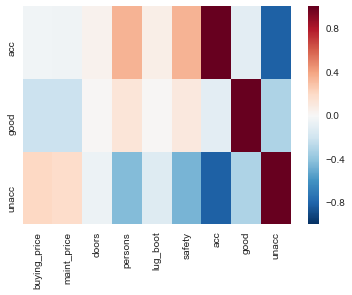

In [48]:
#Let's visualize the correlation between the features and class columns
sns.heatmap(cars[cars.columns].corr()[-3:])

------

For the making of these models, we will only be using 'unacc' as the target column. Therefore we will be testing to see if the car is deemed unacceptable, or not (acceptable, good, or very good).

In [77]:
#Train/Test split
X = cars[cars.columns[:6]]
y = cars.unacc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
#Binary Logisitc Regression Using only 'Unacc' column as target 
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
#Class predictions 
y_pred_test = logreg.predict(X_test)
#Accuracy Score of test data
print "Accuracy Score of our logistic regression model using test data:", metrics.accuracy_score(y_test,
                                                                                                 y_pred_test)

Accuracy Score of our logistic regression model using test data: 0.870905587669


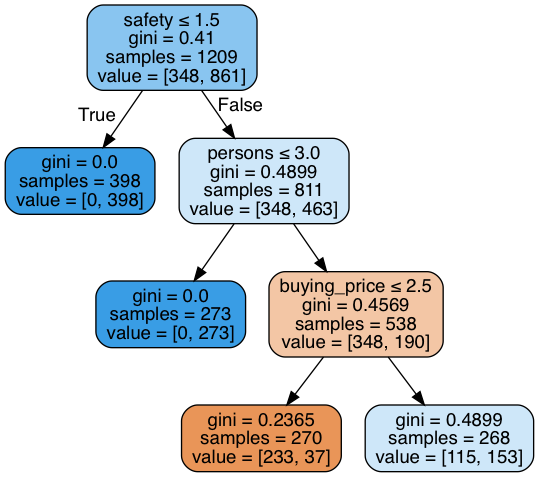

In [78]:
#Classification Decision Tree 
cars_tree = DecisionTreeClassifier(max_depth=3, random_state=1234) #max_depth of 3
cars_tree.fit(X_train, y_train)
#Visualize the tree
dot_data_cars = StringIO()
export_graphviz(cars_tree, out_file=dot_data_cars, feature_names=X_train.columns.tolist(),
                filled=True, rounded=True, special_characters=True)
cars_graph = pydotplus.graph_from_dot_data(dot_data_cars.getvalue())
Image(cars_graph.create_png())

In [79]:
#Check accuracy of tree 
print "Accuracy of our decision tree using test data:", metrics.accuracy_score(y_test, 
                                                                              cars_tree.predict(X_test))

Accuracy of our decision tree using test data: 0.857418111753


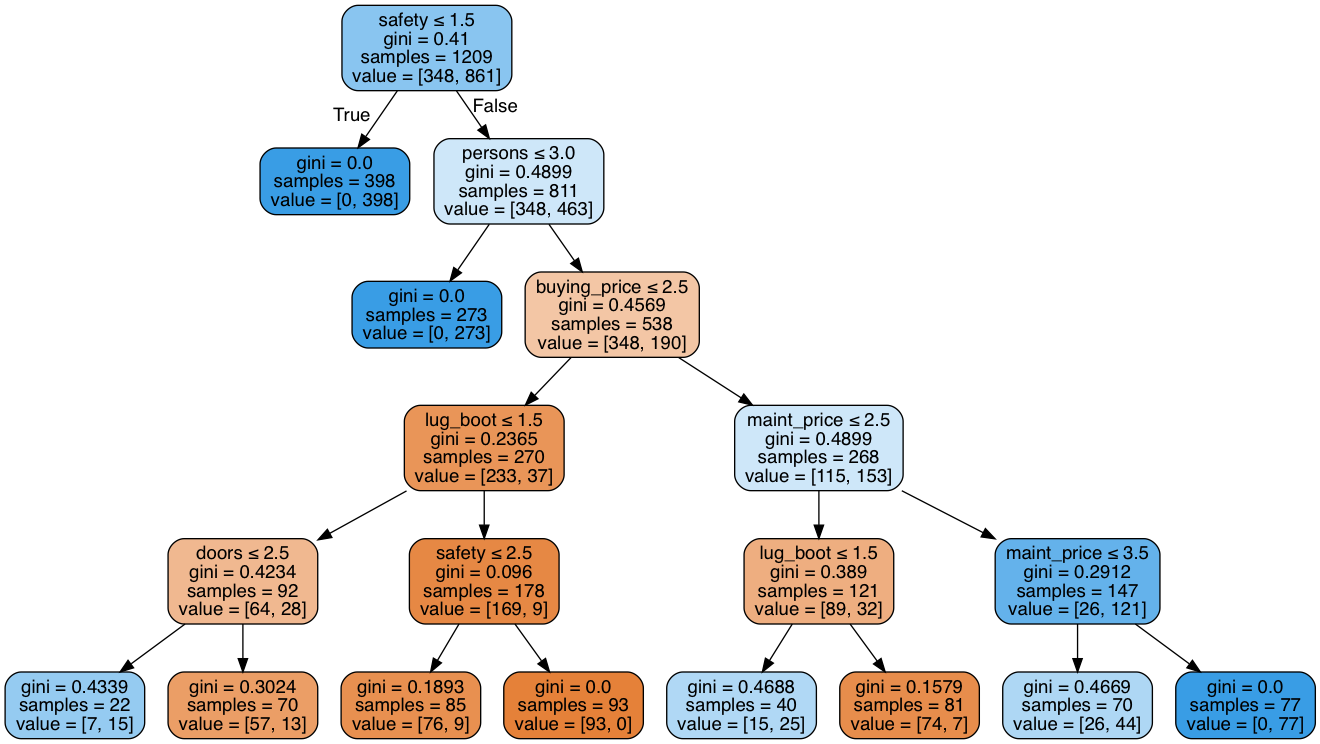

In [266]:
#Let's try our decision tree using a greater max_depth 
cars_tree5 = DecisionTreeClassifier(max_depth=5, random_state=1234) #max_depth of 5
cars_tree5.fit(X_train, y_train)
#Visualize the tree
dot_data_cars = StringIO()
export_graphviz(cars_tree5, out_file=dot_data_cars, feature_names=X_train.columns.tolist(),
                filled=True, rounded=True, special_characters=True)
cars_graph = pydotplus.graph_from_dot_data(dot_data_cars.getvalue())
Image(cars_graph.create_png())

In [267]:
#Check accuracy of tree with greater max_depth 
print "Accuracy:", metrics.accuracy_score(y_test, cars_tree5.predict(X_test))
#Our accuracy increases with greater depth

Accuracy: 0.924855491329


Cars Decision Tree Train|Test Accuracy Score: 0.712158808933 | 0.672447013487
Cars Decision Tree Train|Test Accuracy Score: 0.842845326716 | 0.884393063584
Cars Decision Tree Train|Test Accuracy Score: 0.874276261373 | 0.857418111753
Cars Decision Tree Train|Test Accuracy Score: 0.921422663358 | 0.932562620424
Cars Decision Tree Train|Test Accuracy Score: 0.936311000827 | 0.924855491329
Cars Decision Tree Train|Test Accuracy Score: 0.966087675765 | 0.967244701349
Cars Decision Tree Train|Test Accuracy Score: 0.981803143093 | 0.949903660886
Cars Decision Tree Train|Test Accuracy Score: 0.991728701406 | 0.980732177264
Cars Decision Tree Train|Test Accuracy Score: 0.995037220844 | 0.980732177264
Cars Decision Tree Train|Test Accuracy Score: 0.999172870141 | 0.984585741811


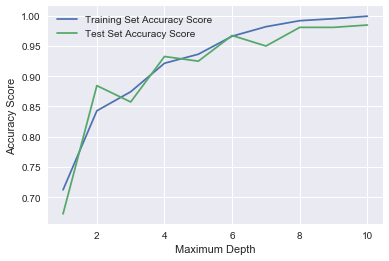

In [52]:
#Tracking performance of decision tree using different depths (1 - 10)
depths = range(1, 11)
train_accuracy = []
test_accuracy = []
for depth in depths:
    cars_tree = DecisionTreeClassifier(max_depth=depth, random_state=1234)
    cars_tree.fit(X_train, y_train)
    curr_train_accuracy = metrics.accuracy_score(y_train, cars_tree.predict(X_train))
    curr_test_accuracy = metrics.accuracy_score(y_test, cars_tree.predict(X_test))
    print "Cars Decision Tree Train|Test Accuracy Score:", curr_train_accuracy, '|', curr_test_accuracy
    train_accuracy.append(curr_train_accuracy)
    test_accuracy.append(curr_test_accuracy)
sns.mpl.pyplot.plot(depths, train_accuracy, label='Training Set Accuracy Score')
sns.mpl.pyplot.plot(depths, test_accuracy, label='Test Set Accuracy Score')
sns.mpl.pyplot.xlabel('Maximum Depth')
sns.mpl.pyplot.ylabel('Accuracy Score')
sns.mpl.pyplot.legend()

In [80]:
#An example of our best single decision tree
best_tree = DecisionTreeClassifier(max_depth=10, random_state=1234)
best_tree.fit(X_train, y_train)
print "Accuracy score for our best single decision tree:", metrics.accuracy_score(y_test,
                                                                                  best_tree.predict(X_test))

Accuracy score for our best single decision tree: 0.984585741811


In [54]:
#Which features are most important?
pd.DataFrame({'Feature':X_train.columns.tolist(),
              'Importance':best_tree.feature_importances_}).sort_values('Importance',
                                                                        ascending=False)

,Feature,Importance
3,persons,0.331339
5,safety,0.264606
0,buying_price,0.148623
1,maint_price,0.138703
4,lug_boot,0.081521
2,doors,0.035209


Seems number of people the car can fit and safety ranking of the car are the most important features in determining evaluation rating.

In [55]:
#Random Forest Approach
#RandomForestClassifier using 500 trees
cars_rf = RandomForestClassifier(n_estimators=500, bootstrap=True,
                                 oob_score=True, random_state=1234)
cars_rf.fit(X_train, y_train)
#Printing out accuracy score
print "Random Forest Accuracy Score(test data):", metrics.accuracy_score(y_test,
                                                                        cars_rf.predict(X_test))

Random Forest Accuracy Score(test data): 0.996146435453


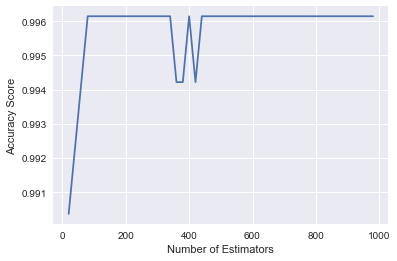

In [56]:
#Let's see how our random forest would perform using different numbers of trees 
estimators = range(20, 1000, 20)
accuracy_scores = []

for estimator in estimators:
    cars_rf = RandomForestClassifier(n_estimators=estimator, bootstrap=True, oob_score=True, random_state=1234)
    cars_rf.fit(X_train, y_train)
    accuracy = metrics.accuracy_score(y_test, cars_rf.predict(X_test))
    accuracy_scores.append(accuracy)
    
sns.mpl.pyplot.plot(estimators, accuracy_scores)
sns.mpl.pyplot.xlabel("Number of Estimators")
sns.mpl.pyplot.ylabel("Accuracy Score")

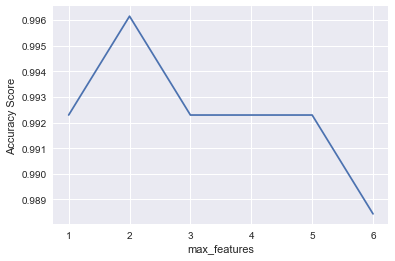

In [57]:
#And now using different numbers of max_features
cars_features = X_train.columns.tolist()
features = range(1, len(cars_features)+1) 
accuracy_scores = []

for feature in features:
    cars_rf = RandomForestClassifier(n_estimators=500, bootstrap=True, oob_score=True,
                                    max_features = feature, random_state=1234)
    cars_rf.fit(X_train, y_train)
    accuracy = metrics.accuracy_score(y_test, cars_rf.predict(X_test))
    accuracy_scores.append(accuracy)
    
sns.mpl.pyplot.plot(features, accuracy_scores)
sns.mpl.pyplot.xlabel("max_features")
sns.mpl.pyplot.ylabel("Accuracy Score")

In [82]:
#Putting together our random forest that will give us the best accuracy score 
best_rf = RandomForestClassifier(n_estimators=600, bootstrap=True, oob_score=True,
                                max_features=2, random_state=1234)
best_rf.fit(X_train, y_train)
print "Accuracy of our best random forest:", metrics.accuracy_score(y_test,
                                                                    best_rf.predict(X_test))

Accuracy of our best random forest: 0.996146435453


#### Evaluating performance using a cross-validation approach.

In [73]:
from sklearn.model_selection import cross_val_score

#Cross validation using basic logisitc regression model
print("Mean cv-accuracy using logistic regression model, 10 folds:",
      np.mean(cross_val_score(logreg,X,y,scoring='accuracy',cv=10)))

('Mean cv-accuracy using logistic regression model, 10 folds:', 0.87089998655733292)


In [59]:
#Cross validation can potentially improve the results of a model
#Using our best_rf random forest
cross_val_scores = cross_val_score(best_rf,X,y,cv=25) #Using 25 folds 
print "25-fold accuracy scores:\n", cross_val_scores
print "Mean cv-accuracy:\n", np.mean(cross_val_scores)
print "Standard Deviation of cv-accuracy:\n", np.std(cross_val_scores)
#Mean accuracy and standard deviation will likely increase as number of folds increases 

25-fold accuracy scores:
[ 0.98571429  1.          0.98571429  0.92857143  0.92857143  1.
  0.97142857  1.          1.          0.97142857  1.          0.95652174
  0.98550725  0.98550725  0.98550725  0.95652174  0.89855072  0.98550725
  0.92647059  1.          0.94117647  1.          1.          1.          1.        ]
Mean cv-accuracy:
0.975707952746
Standard Deviation of cv-accuracy:
0.0291697956181


It seems a random forest approach provides us with the best results and highest accuracy. However, the results of the random forest are comparable to the results of the single decision tree with a high number of splits. 

Regardless, using a random forest with all of the features still provides us with slightly higher accuracy than using a single decision tree with a large max_depth. For many classification problems, it can be expected that a random forest model will out perform a single decision tree.  

After exploring this dataset, it can be reasonably inferred that even a basic logistic regression model can predict whether a car will be unaccepted or not unaccepted as it attempts to pass its evaluation with a confident amount of accuracy. A decision tree or random forest can predict whether the car will pass or not with higher accuracy. It is important to note that persons and safety are the two key predictive features, and a random forest can make predictions with extremely high accuracy using only those two features. 